# <ins> Random-Forest-Classifier für die Diabetes-Vorhersage</ins>

In [4]:
# Bibliotheken importieren
import pandas                as pd
import numpy                 as np
import matplotlib.pyplot     as plt
import seaborn               as sns
import os
import joblib

from sklearn.ensemble        import RandomForestClassifier
from sklearn.linear_model    import LogisticRegression
from sklearn.tree            import DecisionTreeClassifier
from sklearn.svm             import SVC
from sklearn.preprocessing   import StandardScaler
from sklearn.metrics         import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split, ShuffleSplit, GridSearchCV

## <ins> Daten laden und vorbereiten </ins>
Im ersten Schritt werden die Daten geladen und wichtige Statistiken angezeigt.

In [5]:
# Daten laden
diabetes_data = pd.read_csv('../diabetes.csv')

# Statistiken anzeigen lassen
diabetes_data.info()     # gibt Basisinformationen von allen Spalten an

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               2000 non-null   int64  
 1   Glucose                   2000 non-null   int64  
 2   BloodPressure             2000 non-null   int64  
 3   SkinThickness             2000 non-null   int64  
 4   Insulin                   2000 non-null   int64  
 5   BMI                       2000 non-null   float64
 6   DiabetesPedigreeFunction  2000 non-null   float64
 7   Age                       2000 non-null   int64  
 8   Outcome                   2000 non-null   int64  
dtypes: float64(2), int64(7)
memory usage: 140.8 KB


In [6]:
# Zeigt alle Spalten des Datensatzes an
diabetes_data.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

In [32]:
# gibt die ersten x Zeilen zurück, bei head(x). 
# ohne eine definierte Zahl werden die ersten 5 Zeilen zurückgegeben
diabetes_data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,2,138,62,35,0,33.6,0.127,47,1
1,0,84,82,31,125,38.2,0.233,23,0
2,0,145,0,0,0,44.2,0.630,31,1
3,0,135,68,42,250,42.3,0.365,24,1
4,1,139,62,41,480,40.7,0.536,21,0


In [8]:
 # gibt grundlegende Statistiken zu numerischen Spalten zurück 
diabetes_data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,3.703500,121.182500,69.145500,20.935000,80.254000,32.193000,0.470930,33.090500,0.342000
std,3.306063,32.068636,19.188315,16.103243,111.180534,8.149901,0.323553,11.786423,0.474498
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,63.500000,0.000000,0.000000,27.375000,0.244000,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,40.000000,32.300000,0.376000,29.000000,0.000000
75%,6.000000,141.000000,80.000000,32.000000,130.000000,36.800000,0.624000,40.000000,1.000000
max,17.000000,199.000000,122.000000,110.000000,744.000000,80.600000,2.420000,81.000000,1.000000


<div class="alert alert-block alert-info">
<b>Anmerkung:</b> Bei genauerer Betrachtung der Daten fällt auf, dass in den Spalten <span style="font-family:Courier New">BloodPressure</span>, <span style="font-family:Courier New">SkinThickness</span> und <span style="font-family:Courier New">Insulin</span> Werte von 0 enthalten sind. Diese Werte sind inhaltlich wenig sinnvoll, da sie keinen informativen Beitrag für das Modell leisten und die Genauigkeit der Vorhersagen beeinträchtigen können. Daher sollten die Daten vor der Analyse bereinigt werden. Dabei ist zu beachten, dass ein Wert von 0 nicht mit einem fehlenden Wert (<span style="font-family:Courier New">NaN</span>) gleichzusetzen ist.
</div>


## <ins> Visualisierung der Daten </ins>
Als Nächstes werden die Daten visualisiert, mithilfe einer Heatmap und ein Countplot für die Zielvariable `Outcome`.

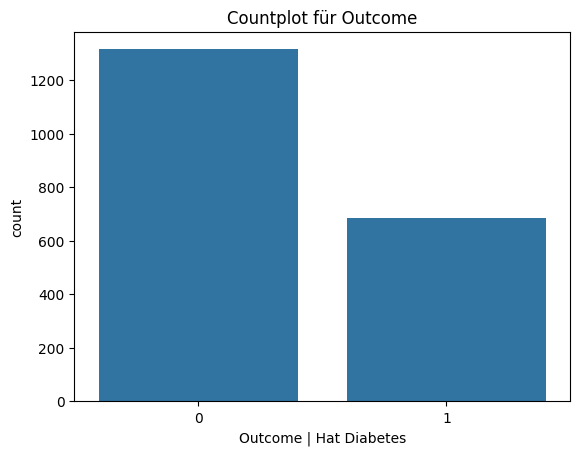

In [9]:
# Countplot für die Zielvariable 'Outcome'
sns.countplot(x = 'Outcome', data = diabetes_data)
plt.title("Countplot für Outcome")
plt.xlabel("Outcome | Hat Diabetes")
plt.show()

<ins>Interpretation **Countplot:**</ins> zeigt die Häufigkeit der Werte der Zielvariable `Outcome` an.
- Outcome = 0 (kein Diabetes): erzielt einen Wert von ungefähr mehr als 1.200.
- Outcome = 1 (Diabetes): erzielt einen Wert von etwa 600.

Hierraus lässt sich sagen, dass der Datensatz unausgewogen ist, da die Klasse 0 (kein Diabetes) häufiger vorkommt als die Klasse 1 (Diabetes). Ein unausgewogener Datensatz kann die Leistung eines Modells beeinträchtigen, da es dazu neigt, die häufigere Klasse 0 zu bevorzugen.

Eine mögliche Lösung zur Behandlung des unausgewogenen Datensatzes ist der Einsatz der SMOTE-Methode (Synthetic Minority Oversampling Technique), um die Häufigkeit der selteneren Klasse zu erhöhen und ein besseres Gleichgewicht herzustellen.

## <ins> Daten Bereinigen </ins>
In diesem Schritt werden die Daten auf fehlende Werte (`NaN`) überprüft. Anschließend werden Werte die mit 0 vorhergesehen wurden in NaN-Werte konvertiert.

In [10]:
# Prüfen, ob fehlende Werte (NaN) pro Spalte vorhanden sind
diabetes_data.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

Im Datensatz existieren keine NaN-Werte, jedoch sind manche Daten mit 0 definiert.

<div class="alert alert-block alert-info">
<b>Anmerkung:</b> Sollten fehlende Werte (<span style="font-family:Courier New">NaN</span>-Werte) im Datensatz auftauchen, wäre eine Möglichkeit die fehlenden Werte mit dem numerischen Mittelwert zu ersetzen (bei kategorische Daten mit dem Modus) oder ggf. die fehlenden Daten entfernen.
</div>

Im nächsten Schritt wird die Datenverteilung analysiert.

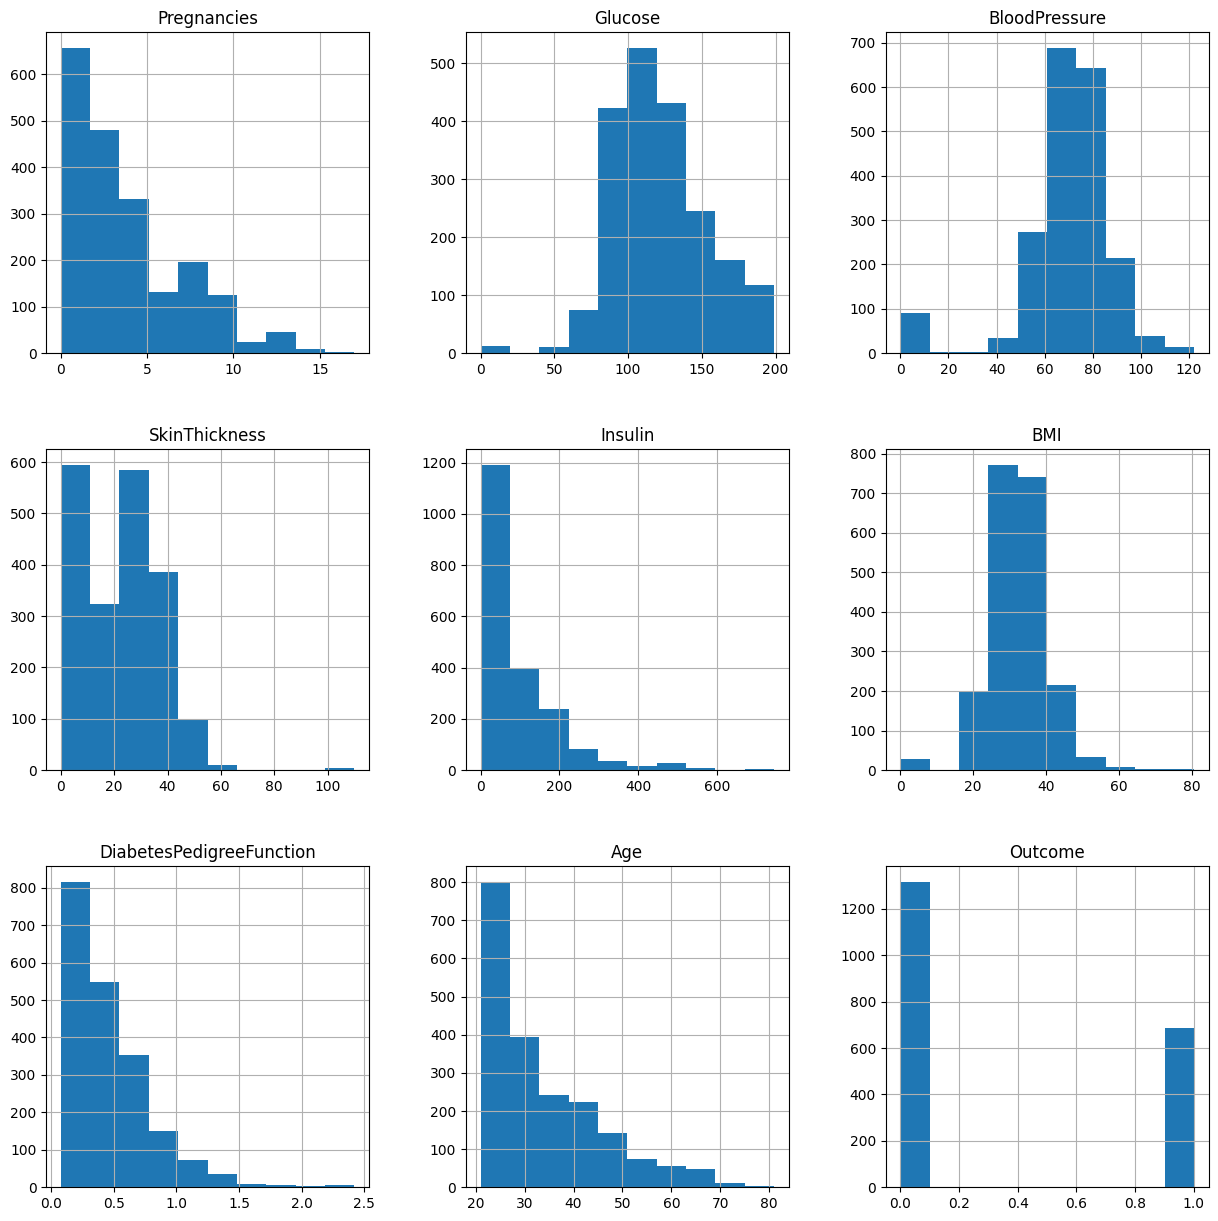

In [11]:
# erstellt ein Histogramm des Datensatzes vor dem Ersetzen von NaN-Werten
hist = diabetes_data.hist(figsize = (15, 15))

Das Histogramm zeigt, dass manche Features den Wert 0 beinhalten, beispielsweise das Feature `Glucose`. Solche Werte sind nicht sinnvoll um das Modell zu trainieren, daher werden diese Werte in NaN konvertiert und anschließend mit dem Mittelwert bzw. Median ersetzt.

In [12]:
# ersetzen der 0-Werte für Glucose, BloodPressure, SkinThickness, Insulin und BMI mit NaN
diabetes_data_copy           = diabetes_data.copy(deep = True) # kopiert den Datensatz
features                     = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

diabetes_data_copy[features] = diabetes_data_copy[features].replace(0, np.NaN) # ersetzt die 0-Werte mit NaN für die features
diabetes_data_copy.isnull().sum()

Pregnancies                   0
Glucose                      13
BloodPressure                90
SkinThickness               573
Insulin                     956
BMI                          28
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

Als nächstes werden die NaN-Werte durch den Mittelwert bzw. Median der jeweiligen Spalte ersetzt.

In [13]:
# Ersetzen des NaN-Werts durch den Mittelwert/Median 
diabetes_data_copy['Glucose']       = diabetes_data_copy['Glucose'].fillna(diabetes_data_copy['Glucose'].mean())
diabetes_data_copy['BloodPressure'] = diabetes_data_copy['BloodPressure'].fillna(diabetes_data_copy['BloodPressure'].mean())
diabetes_data_copy['SkinThickness'] = diabetes_data_copy['SkinThickness'].fillna(diabetes_data_copy['SkinThickness'].median())
diabetes_data_copy['Insulin']       = diabetes_data_copy['Insulin'].fillna(diabetes_data_copy['Insulin'].median())
diabetes_data_copy['BMI']           = diabetes_data_copy['BMI'].fillna(diabetes_data_copy['BMI'].median())

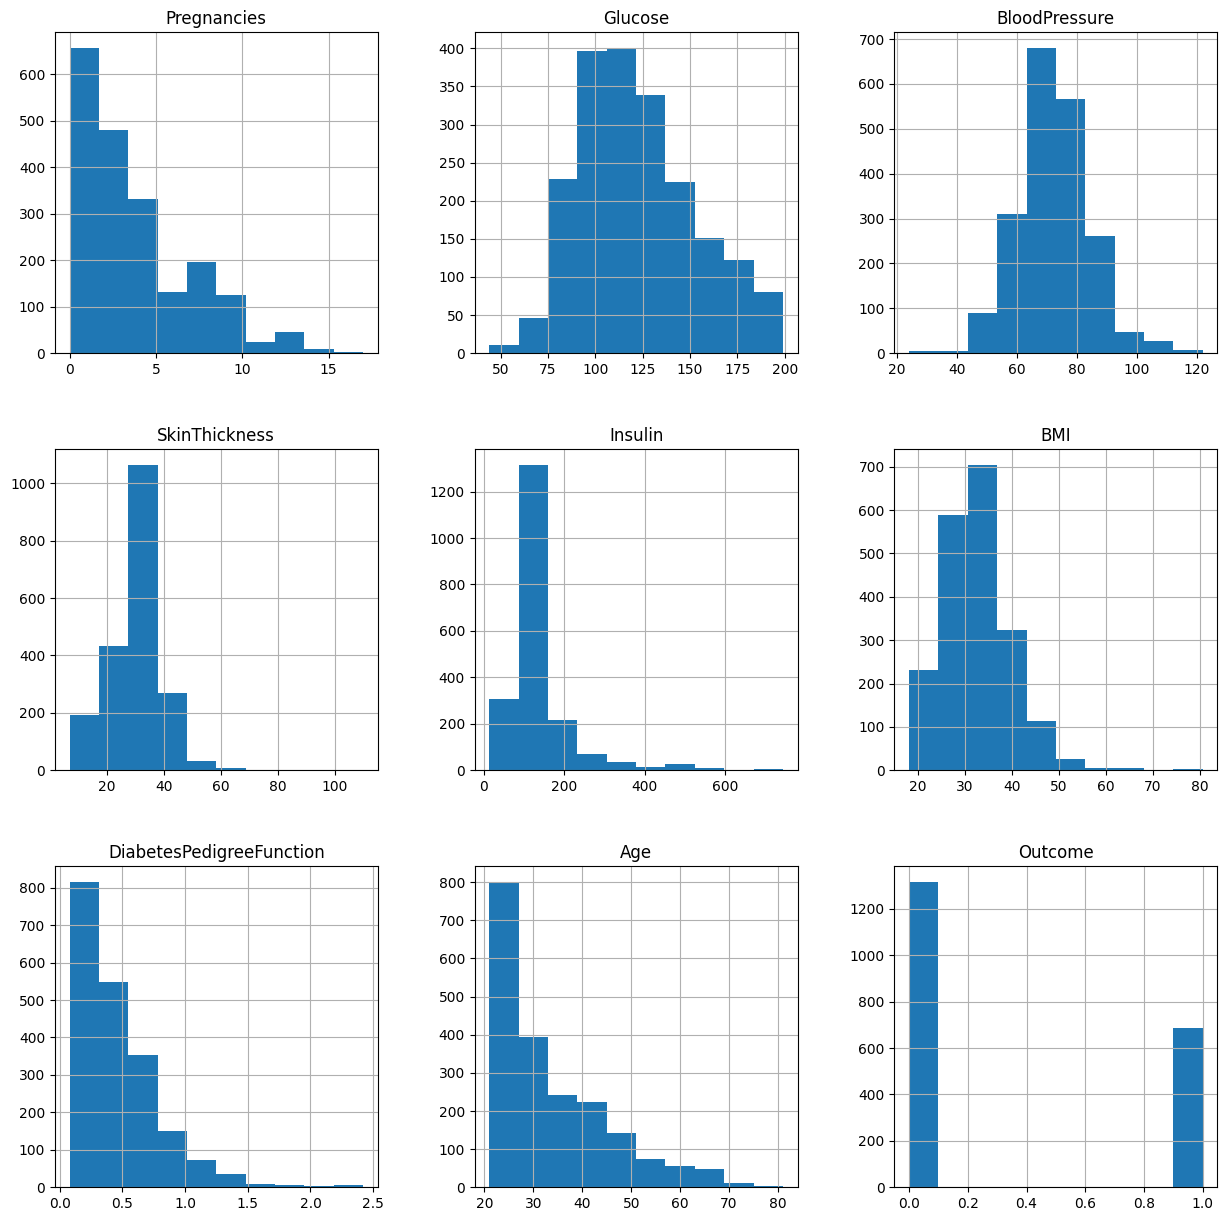

In [14]:
# Histogramm nach der konvertierungg der 0-Werte in NaN
hist = diabetes_data_copy.hist(figsize = (15, 15))

In [15]:
# Überprüpfen der fehlenden Werte (NaN)
diabetes_data_copy.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

## <ins> Datenaufteilung und Skallierung </ins>
Die Daten werden in unabhängige (X) und abhängige (y) Variable aufgeteilt. Anschließend werden die Daten in Trainings- und Testdaten aufgeteilt, wobei 20% der Daten für die Evaluierung zurückgehalten werden und anschließend skaliert.

<div class="alert alert-block alert-info">
<b>Anmerkung:</b> <span style="font-family:Courier New">random_state=42:</span> legt einen Startpunkt für den Zufallszahlengenerator fest. Durch das Festlegen dieses Wertes wird die Zufälligkeit kontrolliert. So wird bei jedem Durchlauf dieselbe zufällige Aufteilung der Daten in Trainings- und Testdaten durchgeführt. Bei keiner Festlegung von <span style="font-family:Courier New">random_state</span>, wird bei jedem Aufruf von <span style="font-family:Courier New">train_test_split</span> eine andere Aufteilung erzeugt, welches bei der Reproduktion von Ergebnissen problematisch sein kann.
</div>

In [16]:
# Unabhängige Variable (X) und abhängige Variable (y) auswählen
X = diabetes_data.drop('Outcome', axis = 1)    # alle Features bis auf die Zielvariable 'Outcome'
y = diabetes_data['Outcome']                   # Zielvariable 'Outcome'

In [17]:
# Aufteilen der Daten in Trainingsdaten und Testdaten
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [18]:
# skalieren der Daten
sc = StandardScaler()

X_train_scaled = sc.fit_transform(X_train)
X_test_scaled  = sc.transform(X_test)

## <ins> Modell erstellen und trainieren </ins>
Hier wird der RandomForest-Classifier erstellt und trainiert.

In [19]:
# Random Forest-Klassifikator erstellen
rf_clf_model = RandomForestClassifier(random_state = 42)

# Modell trainieren
rf_clf_model.fit(X_train_scaled, y_train)

RandomForestClassifier(random_state=42)

## <ins> Modellbewertung </ins>
In diesem Schritt werden Vorhersagen getroffen und das Modell wird basierend auf Metriken wie Genauigkeit, Präzision, Recall und F1-Score bewertet.

In [20]:
# Vorhersage treffen
y_pred = rf_clf_model.predict(X_test_scaled)

# Modellbewertung
metriken = {
    "accuracy"  : accuracy_score (y_test, y_pred),
    "precision" : precision_score(y_test, y_pred),
    "recall"    : recall_score   (y_test, y_pred),
    "F1-Score"  : f1_score       (y_test, y_pred)
}

# Ausgabe der Metriken
for metrik, wert in metriken.items():
    print(f"{metrik}: {wert}")

accuracy: 0.99
precision: 0.9863945578231292
recall: 0.9863945578231292
F1-Score: 0.9863945578231292


<ins>**Analyse der Metriken:**</ins> <br>

- **Accuracy (Genauigkeit):** 0.99
 zeigt an, wie viele Vorhersagen insgesamt richtig waren. <br>
 Mit einer Genauigkeit von 99% zeigt das Modell eine hohe Zuverlässigkeit bei der Klassifikation.

- **Precision (Präzision):** 0.986
 gibt an, wie genau die positiven Vorhersagen waren. z.B. von 10 Vorhersagen waren nur 7 wirklich richtig. <br>
 Eine Präzision von 98.6% bedeutet, dass das Modell fast alle als "Diabetes" vorhergesagten Fälle korrekt klassifiziert hat.   

- **Recall (Sensitivität):** 0.986
 zeigt, wie viele der tatsächlichen positiven Fälle korrekt erkannt wurden.<br>
 Mit einem Recall von 98.6% zeigt das Modell eine starke Fähigkeit, Diabetes-Fälle zuverlässig zu erkennen.
 <br>

- **F1-Score:** 0.986
 Kombination aus Precision und Recall, die das Gleichgewicht zwischen beiden bewertet. Nützlich wenn die Daten unausgewogen sind. <br>
 Mit einem F1-Score von 98.6% zeigt das Modell ein gutes Gleichgewicht zwischen Präzision und Recall.



Die Metriken sehen außergewöhnlich gut aus, was darauf hinweist, dass es effektiv und zuverlässig für die Vorhersage von Diabetes eingesetzt werden kann. Diese Ergebnisse verdeutlichen, dass die Datenbereinigung und das gewählte Modell die gewünschte Performance liefern, Jedoch könnte das Modell auf mögliche Probleme hinweisen. Da der Datensatz relativ unausgewogen ist (siehe Countplot) sollten weitere Maßnahmen ergriffen werden um sicherzustellen, dass das Modell nicht Überangepasst (Overfittet) ist.

### <ins> **Konfusionsmatrix** </ins>
Die Konfusionsmatrix zeigt die Anzahl der richtigen und falschen Vorhersagen an.

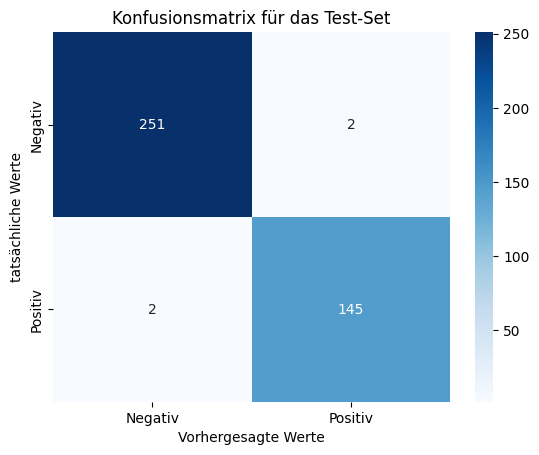

In [21]:
# Konfusionsmatrix für das Test-Set erstellen
cm_test = confusion_matrix(y_test, y_pred)

sns.heatmap(cm_test, annot = True, fmt = "d", cmap = "Blues", xticklabels = ['Negativ', 'Positiv'], yticklabels = ['Negativ', 'Positiv'])
plt.title("Konfusionsmatrix für das Test-Set")
plt.xlabel('Vorhergesagte Werte')
plt.ylabel('tatsächliche Werte')
plt.show()

#### <ins> **Erklärung der Werte für das Test-Set** </ins>
- **True Negatives (TN):** 251  
  Das Modell hat 251 Fälle korrekt als negativ (kein Diabetes) klassifiziert.
  
- **False Positives (FP):** 2  
  Das Modell hat 2 Fälle fälschlicherweise als positiv (Diabetes) klassifiziert.

- **False Negatives (FN):** 2  
  Es gibt 2 Fälle, bei denen das Modell Diabetes fälschlicherweise nicht erkannt hat.

- **True Positives (TP):** 145  
  Das Modell hat 145 Fälle korrekt als positiv (Diabetes) erkannt.

#### <ins> **Analyse** </ins>
- Das Modell zeigt eine gute Klassifikationsleistung:
  - **False Positives (FP):** Die geringe Anzahl (2 Fälle) zeigt, dass das Modell selten Nicht-Diabetes-Fälle fälschlicherweise als Diabetes klassifiziert.
  - **False Negatives (FN):** Nur 2 tatsächliche Diabetes-Fälle wurden übersehen, was auf eine hohe Sensitivität hinweist.
  - **True Positives (TP) und True Negatives (TN):** Mit 145 korrekt erkannten positiven Fällen und 251 korrekt erkannten negativen Fällen ist die Gesamtperformance des Modells sehr gut.



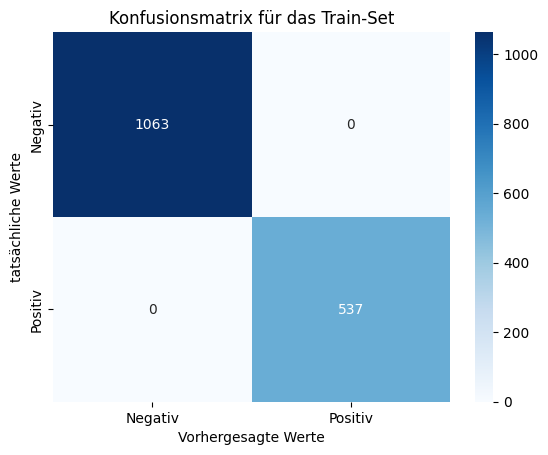

In [22]:
# Konfusionsmatrix für das Training-Set erstellen
y_train_pred = rf_clf_model.predict(X_train_scaled)
cm_train     = confusion_matrix(y_train, y_train_pred)

sns.heatmap(cm_train, annot = True, fmt = "d", cmap = "Blues", xticklabels = ['Negativ', 'Positiv'], yticklabels = ['Negativ', 'Positiv'])
plt.title("Konfusionsmatrix für das Train-Set")
plt.xlabel('Vorhergesagte Werte')
plt.ylabel('tatsächliche Werte')
plt.show()

#### <ins> **Erklärung der Werte für das Train-Set** </ins>
- **True Negatives (TN):** 1063  
  Das Modell hat 1063 Fälle korrekt als negativ (kein Diabetes) klassifiziert.
  
- **False Positives (FP):** 0  
  Das Modell hat keinen Fall fälschlicherweise als positiv klassifiziert.

- **False Negatives (FN):** 0  
  Es gibt keine falsch-negativen Vorhersagen, d. h., das Modell hat keine tatsächlichen Diabetes-Fälle übersehen.

- **True Positives (TP):** 537  
  Das Modell hat 537 Fälle korrekt als positiv (Diabetes) erkannt.

#### <ins> **Analyse** </ins>
- Das Modell zeigt eine perfekte Klassifikationsleistung auf dem Trainings-Set:
  - Es gibt **keine False Positives (FP)** und **keine False Negatives (FN)**, was bedeutet, dass alle Vorhersagen des Modells korrekt sind.
  - Die Kombination aus **hoher Präzision** und **hohem Recall** führt zu einer perfekten Leistung auf den Trainingsdaten.

## <ins> Vorhersagen </ins>
Im folgenden wird eine Funktion erstellt die Vorhersagt, ob Diabetes vorliegt oder nicht.

In [23]:
# Funktion für die Diabetes Vorhersage
def predict_diabetes(Pregnancies, Glucose, BloodPressure, SkinThickness, Insulin, BMI, DPF, Age):
    
    # Konvertieren der Übergabeparameter   
    preg, age                          = int(Pregnancies), int(Age)
    glucose, bp, st, insulin, bmi, dpf = float(Glucose), float(BloodPressure), float(SkinThickness), float(Insulin), float(BMI), float(DPF)
    
    # Speichern der Werte in einem DataFrame
    feature_name = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
    x            = pd.DataFrame([[preg, glucose, bp, st, insulin, bmi, dpf, age]], columns = feature_name)
    
    # # Merkmale mit StandardScaler normalisieren
    x = sc.transform(x)
    
    # Vorhersage wird zurückgegeben
    return rf_clf_model.predict(x)

In [24]:
# Funktion zur Anzeige der Vorhersagergebnisse
def display_prediction(prediction):
    if prediction:
        print("Diabetes Positiv.")
    else:
        print("Diabetes Negativ.")

In [ ]:
# Mehrere Vorhersagen durchführen
# Input: Pregnancies, Glucose, BloodPressure, SkinThickness, Insulin, BMI, DPF, Age
diabetes_predictions = [
    predict_diabetes(2, 81,  72, 15, 76,  30.1, 0.547, 25),
    predict_diabetes(4, 120, 80, 20, 85,  28.7, 0.672, 30),
    predict_diabetes(5, 160, 90, 25, 130, 35.2, 0.6,   50),
    predict_diabetes(1, 90,  70, 18, 50,  25.3, 0.5,   21),
    predict_diabetes(3, 140, 85, 22, 100, 32.1, 0.7,   45),  
    predict_diabetes(0, 180, 95, 30, 150, 40.5, 0.8,   55)   
]

# Ergebnisse anzeigen
for pred in diabetes_predictions:
    display_prediction(pred)

Diabetes Negativ.
Diabetes Negativ.
Diabetes Positiv.
Diabetes Negativ.
Diabetes Positiv.
Diabetes Positiv.


## <ins> Andere Modelle vergleichen </ins>
 Im folgenden werden andere Modelle verglichen wie die logistische Regression, Entscheidungsbaum, Random-Forest und Support Vector Machine (SVM). 

In [26]:
# Unterdrückt Warnungen, hier FutureWarning
# import warnings                          
# warnings.simplefilter(action = 'ignore', category = FutureWarning)

# Funktion zur Bestimmung des besten Machine-Learning-Modells basierend auf Validierungsscores
def find_best_model(X, y):
    
    # Definition der Modelle als Dictionary und ihrer zu optimierenden Hyperparameter
    models = {
        'logistic regression': {
            'model': LogisticRegression(solver = 'lbfgs', max_iter = 200),
            'parameters': {
                'C': [1, 5, 10]
               }
        },
        'decision tree': {
            'model': DecisionTreeClassifier(),
            'parameters': {
                'max_depth': [5, 10]
            }
        },
        'random forest': {
            'model': RandomForestClassifier(random_state = 42),
            'parameters': {
                'n_estimators': [10, 15, 20, 50, 100, 200]
            }
        },
        'svm': {
            'model': SVC(),
            'parameters': {
                'C': [1, 10, 20],
                'kernel': ['rbf','linear']
            }
        }
    }
    
    # Liste zur Speicherung der Ergebnisse
    scores = [] 
    
    # Kreuzvalidierung (Daten werden vor jedem Split zufällig gemischt) mit 5 zufälligen Splits und 20% der Daten als Testdaten
    cv_shuffle = ShuffleSplit(n_splits = 5, test_size = 0.20, random_state = 42) 
    
    # Iteration über jedes Modell und Hyperparameteroptimierung mit GridSearchCV
    for model_name, model_params in models.items():
        gs = GridSearchCV(model_params['model'], model_params['parameters'], cv = cv_shuffle, return_train_score = False)
        gs.fit(X, y)
        
        # Speicherung der Ergebnisse (Modellname, beste Parameter und besten Score)
        scores.append({
            'model'          : model_name,
            'beste_parameter': gs.best_params_,
            'score'          : gs.best_score_
        })
        
    # Rückgabe der Ergebnisse als DataFrame
    return pd.DataFrame(scores, columns = ['model','beste_parameter','score'])

In [27]:
find_best_model(X_train_scaled, y_train)

,model,beste_parameter,score
0,logistic regression,{'C': 5},0.770000
1,decision tree,{'max_depth': 10},0.925625
2,random forest,{'n_estimators': 200},0.961875
3,svm,"{'C': 20, 'kernel': 'rbf'}",0.872500


Die Tabelle zeigt die besten Hyperparameter jedes Modells sowie deren Score (Genauigkeit des Modells).

### <ins> **Erklärung der Ergebnisse:** </ins>

0. **Logistic Regression**:
   - **Beste Hyperparameter:** `C = 5`
   - Das Modell hat eine **Genauigkeit von 77%**, was im Vergleich zu den anderen getesteten Modellen relativ niedrig ist.
   - Die Regularisierung (`C`) wurde auf 5 gesetzt, um das Modell zu optimieren.

1. **Decision Tree**:
   - **Beste Hyperparameter:** `max_depth = 10`
   - Der **Decision Tree** hat eine **Genauigkeit von 92%**, was ein signifikantes Verbesserung gegenüber der logistischen Regression darstellt.
   - Eine maximale Baumtiefe von 10 hat sich als optimal herausgestellt, um Überanpassung (Overfitting) zu vermeiden und die Modellgenauigkeit zu maximieren.

2. **Random Forest**:
   - **Beste Hyperparameter:** `n_estimators = 200`
   - Das **Random Forest**-Modell erzielte die höchste Genauigkeit von **96%**.
   - Mit 200 Bäumen (`n_estimators`) konnte das Modell eine exzellente Leistung erbringen.

3. **Support Vector Machine (SVM)**:
   - **Beste Hyperparameter:** `C = 20, kernel = rbf`
   - Das **SVM-Modell** erzielte eine **Genauigkeit von 87%**. Es hat sich als solide Wahl erwiesen, wenn auch nicht so gut wie der Random Forest.
   - Der Wert von `C` und der Radial Basis Function (`rbf`) Kernel sind die besten Einstellungen, um die Klassifikation zu optimieren.

### <ins> **Fazit:** </ins>
- Das **Random Forest**-Modell hat mit einem Score von **96%** die beste Leistung erzielt und ist das am besten geeignete Modell für diese Klassifikationsaufgabe.
- Andere Modelle wie **Decision Tree** und **SVM** lieferten ebenfalls gute Ergebnisse, wobei **Random Forest** die höchste Genauigkeit erreichte, weshalb dieses Modell für das Projekt ausgewählt wurde.